In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


In [60]:
%%time
modelpath = "data/models/ACTS-10N-25T-260R.h5"
filepath  = "data/sets/ACTS-10N-25T-16539E-260R.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    rs = np.sort(pd.unique(frame["r"]))
    del frame  
    del events  # To save on memory.

Train is list of 13232 events.
Test is list of 3308 events.
Train takes up 105920 bytes.
Test takes up 26528 bytes.
CPU times: user 6.45 s, sys: 10.3 s, total: 16.8 s
Wall time: 16.8 s


In [3]:
order = ["phi", "r", "z"]

In [4]:
input_shape  = (260, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [81]:
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [95]:
def round_noise_up(row):
    if row["noise"] and (row["r"] <= rs[5] or row["r"] == np.NaN):
        row.loc["r"] = np.random.choice(rs[6:])
    return row
test_high = []
for event in test:
    test_high.append(event.apply(round_noise_up, axis=1))

In [96]:
# Noise tends to be far from origin of detector.
guesses_up = model.predict(ext.extract_input(test_high, order))
print(metrics.percent_of_hits_assigned_correctly(test_high, guesses=guesses_up, order=order))

0.909711506004


In [87]:
%%time
def round_noise_down(row):
    if row["noise"] and (row["r"] > rs[5] or row["r"] == np.NaN):
        row.loc["r"] = np.random.choice(rs[:5])
    return row
test_down = []
for event in test:
    test_down.append(event.apply(round_noise_down, axis=1))

CPU times: user 2min 1s, sys: 52 ms, total: 2min 1s
Wall time: 2min 1s


In [88]:
# Noise tends to be close to origin of detector.
guesses_down = model.predict(ext.extract_input(test_down, order))
print(metrics.percent_of_hits_assigned_correctly(test_down, guesses=guesses_down, order=order))

0.752941601967


In [89]:
# Noise is uniformly randomly distributed.
guesses = model.predict(ext.extract_input(test, order))
print(metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order))

0.821605101992


<IPython.core.display.Javascript object>


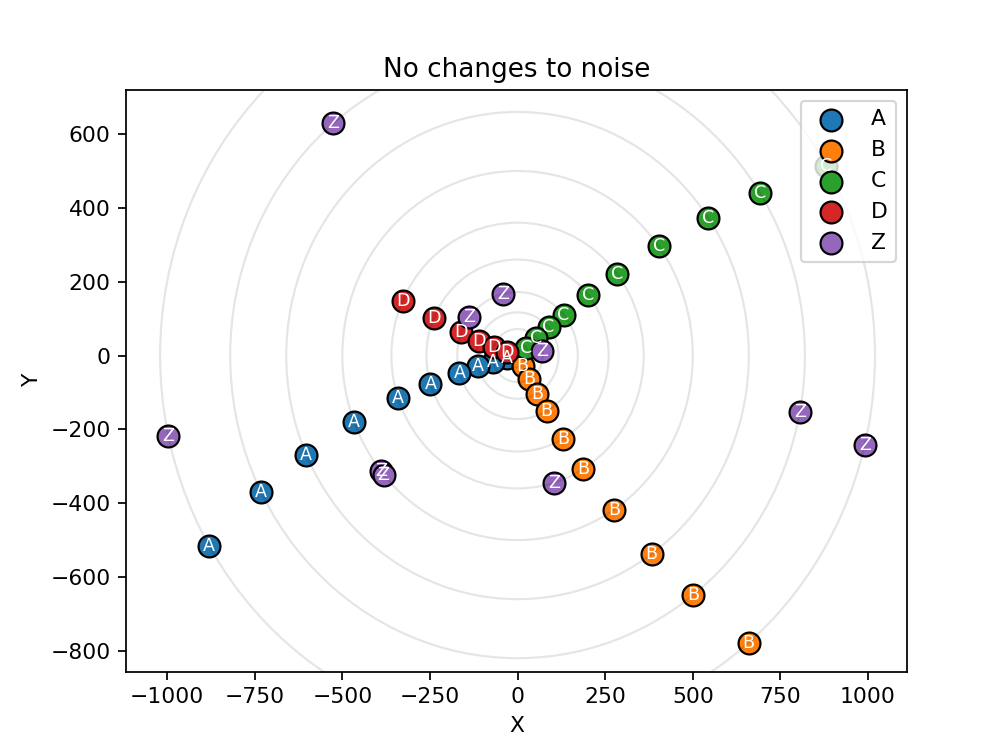

<IPython.core.display.Javascript object>


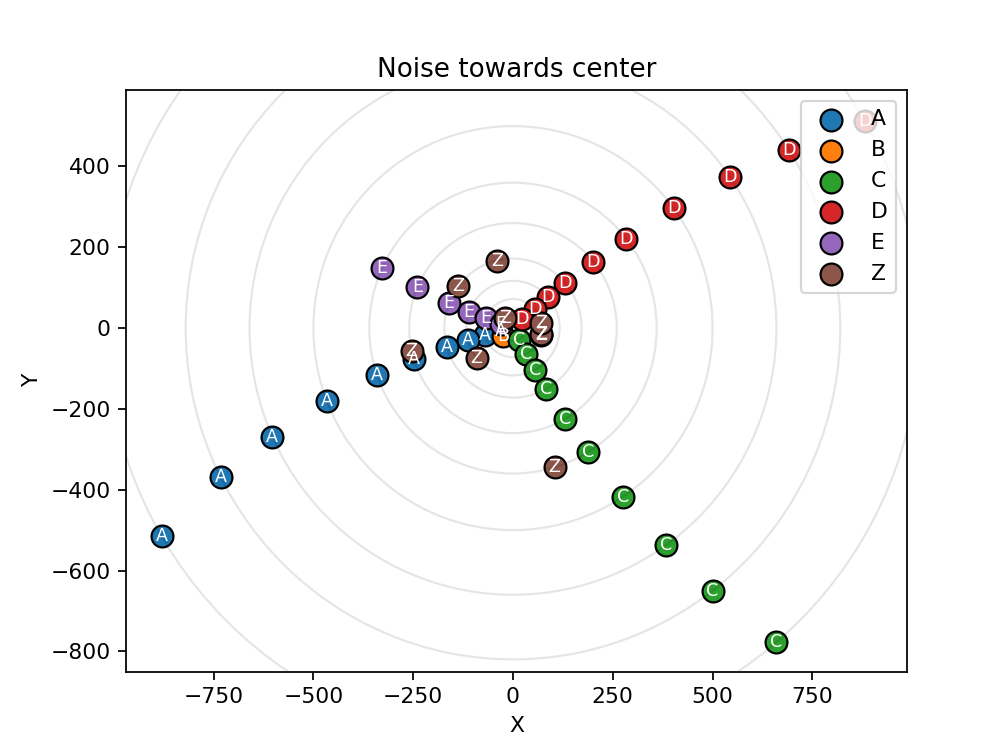

<IPython.core.display.Javascript object>


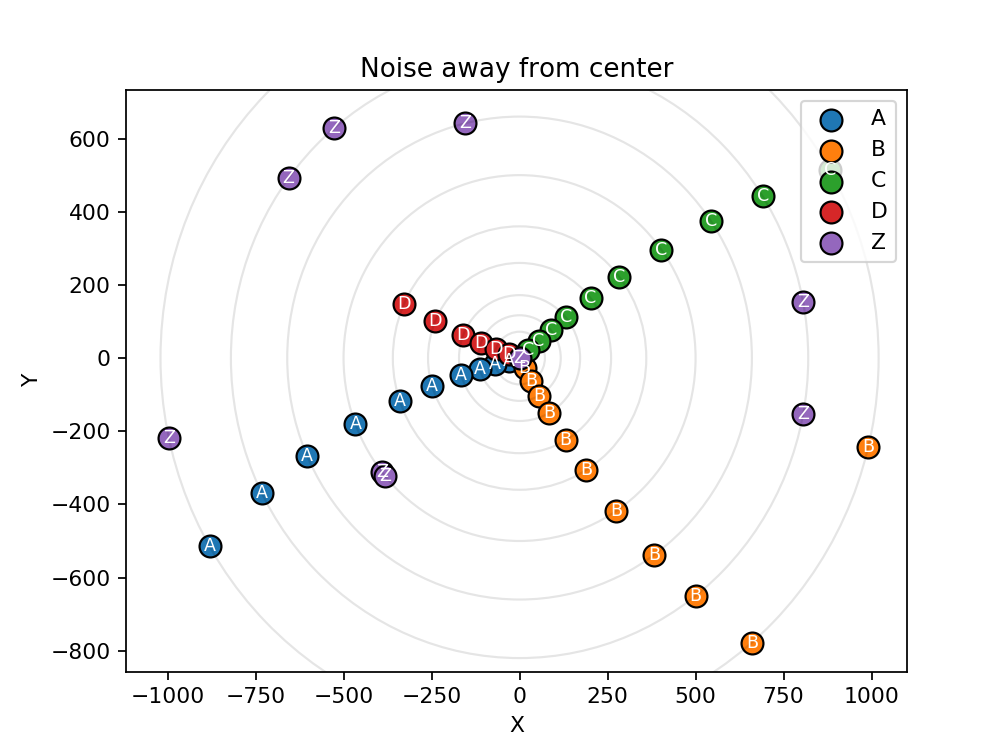

In [98]:
n = 250
visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="No changes to noise")
visuals.Plot2D(test_down[n], order, guesses_down[n]).plot(mode="xy", title="Noise towards center")
visuals.Plot2D(test_high[n], order, guesses_up[n]).plot(mode="xy", title="Noise away from center")